# Предсказание числа багов

## Задача

Построить модель, предсказывающую число багов в будующих пушах.

## Описание данных

Датасет описывает некоторую зависимость числа bugs от значений repository_name, commit_hash, commit_date, commit_author, commit_message. Вам необходимо выявить данную зависимость и написать скрипт/ноутбук, обучающий модель по данному датасету

## Импорт библиотек

In [247]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

In [4]:
import nltk
import spacy
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

In [21]:
from pymystem3 import Mystem

In [208]:
from statsmodels.tsa.seasonal import seasonal_decompose

In [22]:
sns.set_style("whitegrid")

In [26]:
import en_core_web_sm

In [28]:
nlp = en_core_web_sm.load(disable=['parser', 'ner'])
# nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [11]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Vakula\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Vakula\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\wordnet.zip.


True

## 1. Изучение данных

In [29]:
bugs_data = pd.read_csv('train.csv', parse_dates=[2])

Откроем файл и изучим данные.

In [30]:
bugs_data.head()

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
0,mlm,b28abb42,2020-06-12 14:26:12,Victor,объяснения предсказаний с помощью lime,4
1,mlm,438b5c4d,2020-06-12 11:53:10,Victor,Поставил lime вместо eli5,3
2,mlm,8e6e4f31,2020-06-11 15:19:03,Victor,Скрипт для создния пакетов обновления,4
3,mlm,5e0956a6,2020-06-11 10:42:29,Victor,Сортировка весов по убыванию,3
4,mlm,b9f4b40c,2020-06-11 09:25:19,Victor,не надо конвертировать массив до операции по с...,7


In [31]:
bugs_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   repository_name  319 non-null    object        
 1   commit_hash      319 non-null    object        
 2   commit_date      319 non-null    datetime64[ns]
 3   commit_author    319 non-null    object        
 4   commit_message   319 non-null    object        
 5   bugs             319 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 15.1+ KB


In [32]:
bugs_data.repository_name.value_counts()

conductor    114
sensor       102
mlm           41
standard      29
dockers       19
agent         14
Name: repository_name, dtype: int64

In [33]:
bugs_data.commit_author.value_counts()

Victor     134
Mallory     67
Wendy       48
Dabe        42
Eve          9
Trudy        9
Carol        4
Peggy        2
Alice        2
Bob          2
Name: commit_author, dtype: int64

In [34]:
bugs_data.bugs.value_counts()

2     96
3     75
4     51
1     44
5     19
6     10
0      8
7      7
8      3
12     2
9      2
11     1
10     1
Name: bugs, dtype: int64

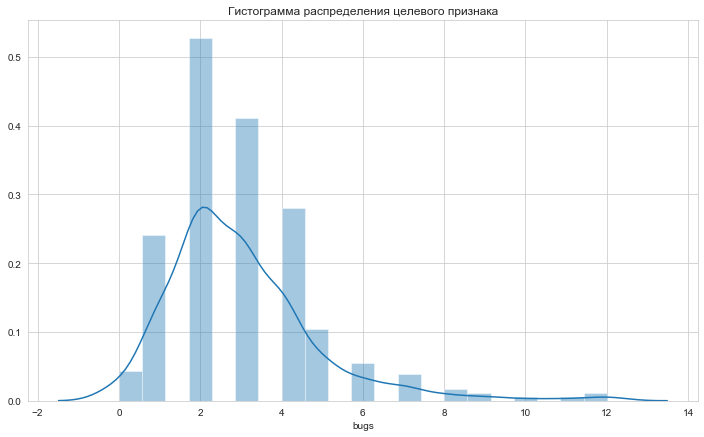

In [35]:
plt.figure(figsize=(12,7))
sns.distplot(bugs_data['bugs'])
plt.title('Гистограмма распределения целевого признака')
plt.show()

Рассмотрим зависимость `repository_name`, `commit_author` от `bugs`.

In [36]:
# oe = OrdinalEncoder()
# bugs_data[['repository_name', 'commit_author']] = oe.fit_transform(bugs_data[['repository_name', 'commit_author']]).astype(int)

Text(0, 0.5, 'repository_name')

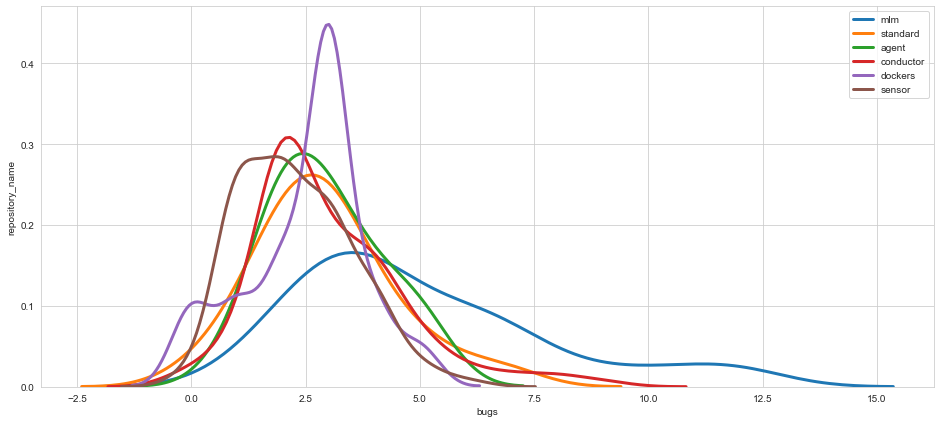

In [37]:
plt.figure(figsize=(16,7))
for name in bugs_data['repository_name'].unique():
    sns.distplot(bugs_data[bugs_data['repository_name'] == name]['bugs'], kde_kws={ "lw": 3, "label": name}, hist=False)
plt.ylabel('repository_name')

На графике, описывающем количество багов в каждом репозитории, практически везде можно наблюдать скошенность распределения. Особенно явно скошен вправо mlm.

Text(0, 0.5, 'commit_author')

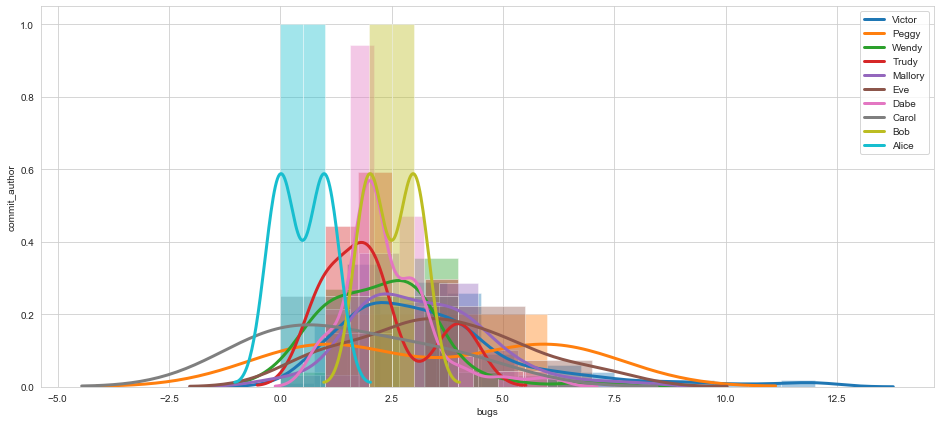

In [38]:
plt.figure(figsize=(16,7))
for author in bugs_data['commit_author'].unique():
    sns.distplot(bugs_data[bugs_data['commit_author'] == author]['bugs'], kde_kws={ "lw": 3, "label": author})
plt.ylabel('commit_author')

На графиках видно, что зависимость `bugs` от `commit_author` присутсвует. На гафике у некоторых авторов есть ярковыраженные пики. К примеру, Bob постоянно делает 2 ошибки, а Alice практически не ошибается. 

Мы можем использовать эти категориальные признаки для предсказания количества багов.

Изучим даты комитов.

In [148]:
date_weekdays = bugs_data['commit_date'].dt.weekday
date_days = bugs_data['commit_date'].dt.date.sort_values(ignore_index=True)

In [138]:
date_weekdays_bugs = pd.concat([date_weekdays, bugs_data['bugs']], axis=1).pivot_table(index='commit_date', aggfunc='sum')
date_weekdays_bugs.T

commit_date,0,1,2,3,4,5,6
bugs,121,65,253,174,229,40,74


In [214]:
date_days_bugs = bugs_data[['commit_date','bugs']]
date_days_bugs.index = date_days_bugs['commit_date']
date_days_bugs = date_days_bugs.drop('commit_date', axis=1)
date_days_bugs = date_days_bugs.resample('1d').sum()
date_days_bugs.head()

,bugs
commit_date,
2020-03-08,45
2020-03-09,30
2020-03-10,0
2020-03-11,0
2020-03-12,0


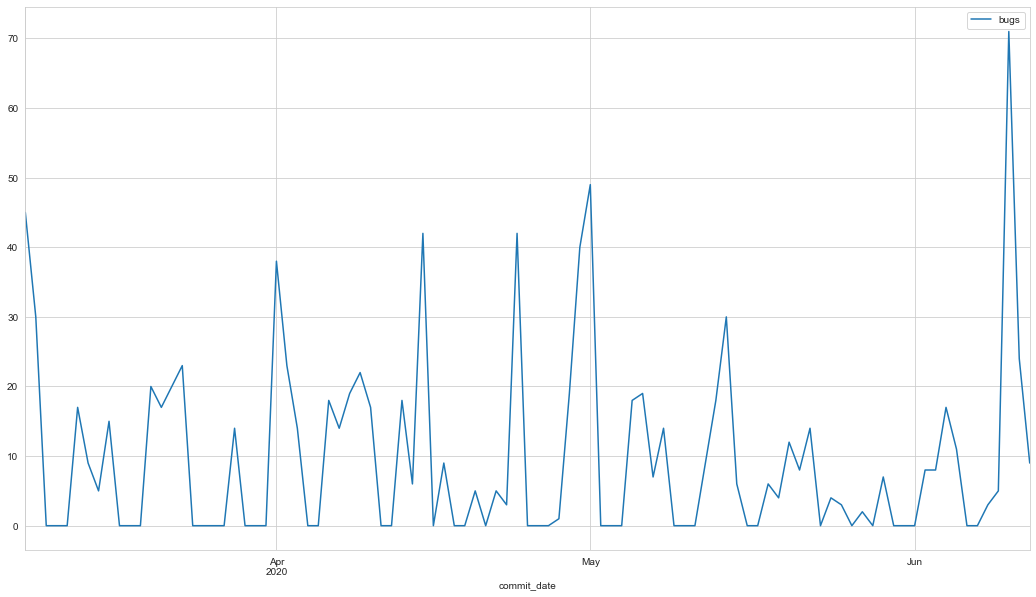

In [209]:
date_days_bugs.plot(figsize=(18,10))

Рассмотрим тренд и сезонность.

In [210]:
decompose = seasonal_decompose(date_days_bugs)

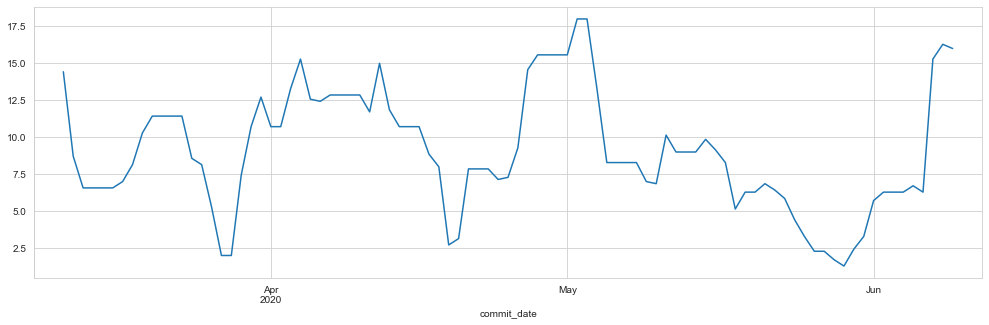

In [211]:
decompose.trend.plot(figsize=(17,5), grid = True)

В данных отсутсвует четко выраженные тренд.

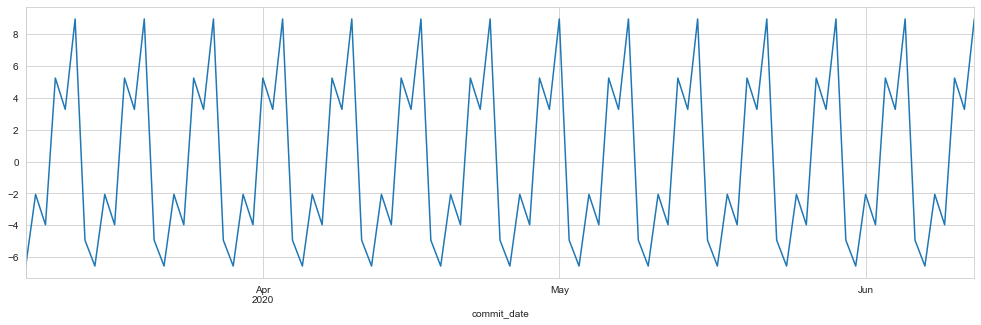

In [213]:
decompose.seasonal.plot(figsize=(17,5), grid = True)

Здесь мы можем наблюдать, что присутсвует рост числа багов к пятнице. 

Рассмотрим данные по дням недели.

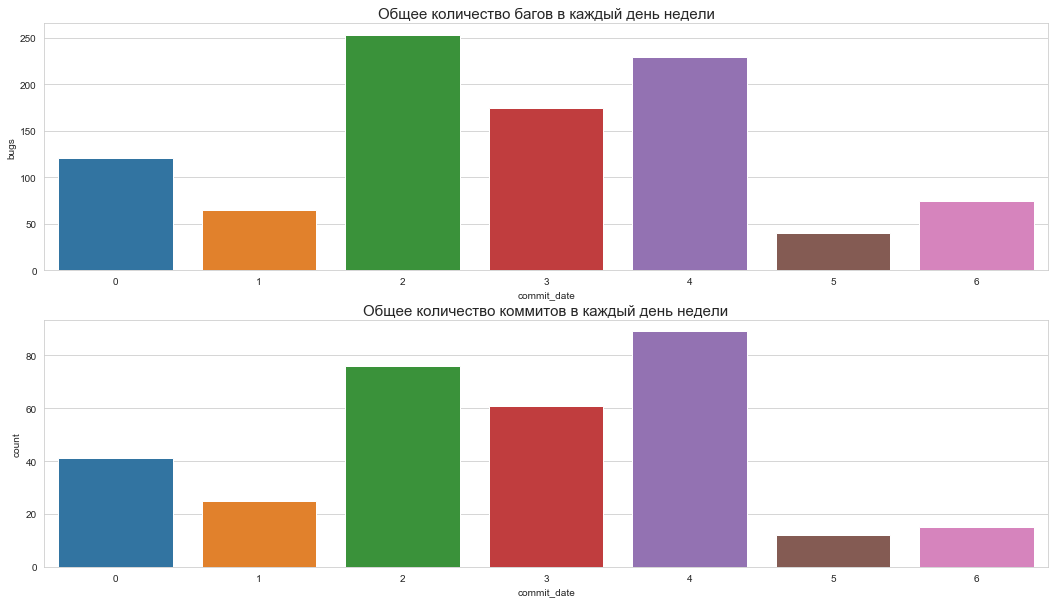

In [140]:
f, (ax1, ax2) = plt.subplots(2, 1, figsize=(18,10))
ax1.set_title('Общее количество багов в каждый день недели', fontsize=15)
ax2.set_title('Общее количество коммитов в каждый день недели', fontsize=15)
sns.barplot(x=date_weekdays_bugs.index, y='bugs', data=date_weekdays_bugs, ci=None, ax=ax1)
sns.countplot(x=date_weekdays, ax=ax2)
plt.show()

В среду, четверг и пятницу больше всего коммитов, и, соответсвенно, больше всего багов. Мы можемиспользовать это в обучении модели.

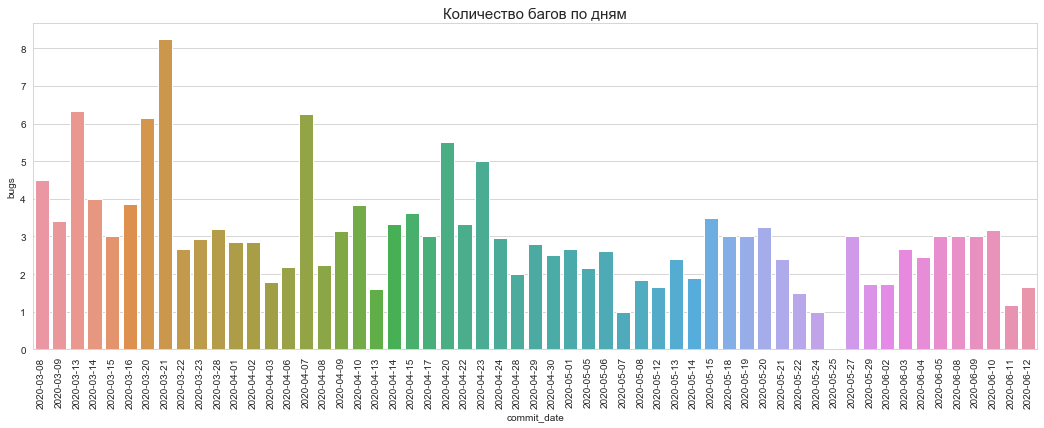

In [167]:
f, ax = plt.subplots( figsize=(18,6))
ax.set_title('Количество багов по дням', fontsize=15)
sns.barplot(x=date_days, y='bugs', data=bugs_data, ci=None, ax=ax)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=90)
plt.show()

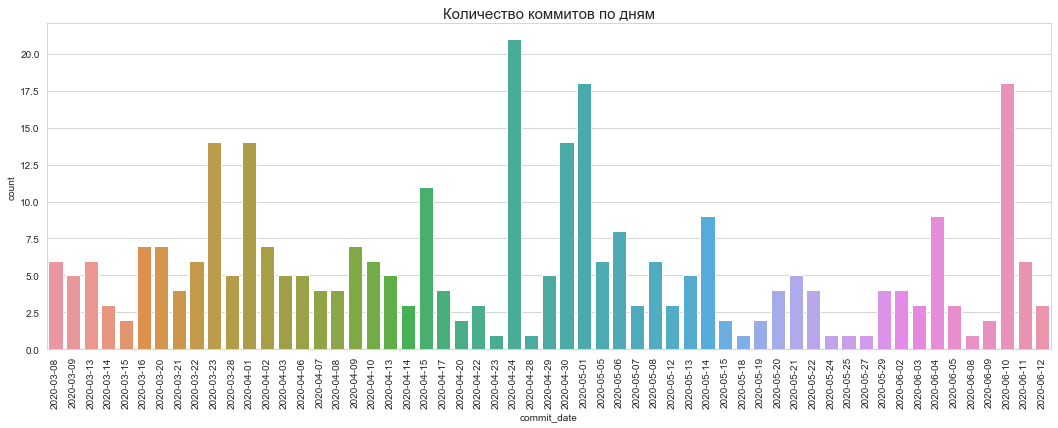

In [165]:
f, ax = plt.subplots( figsize=(18,6))
ax.set_title('Количество коммитов по дням', fontsize=15)
sns.countplot(x=date_days, ax=ax)
labels = ax.get_xticklabels()
plt.setp(labels, rotation=90)
plt.show()

### Вывод

Можно увидеть зависимость количества багов от даты. Однако я считаю, что использовать в обучении можно только дни недели. Потому что:
 1. на граффике нет четкой зависимости количества багов от дня месяца;
 2. даже если бы она была, это может ввести в заблуждение алгоритм. К примеру, найти закономерность, что 20-го числа в среднем бывает 5 багов. 
 
Однако, я считаю, что мы можем использовать дни недели для создания модели. Так как можно проследить недельную сезонность в данных.

## 2. Предобработка данных

Добавим в датасет дни недели и удалим commit_hash и commit_date.

In [215]:
bugs_data['weekday'] = bugs_data['commit_date'].dt.weekday

In [220]:
bugs_data = bugs_data.drop(['commit_hash', 'commit_date'], axis=1)

In [221]:
bugs_data.head()

,repository_name,commit_author,commit_message,bugs,weekday
0,mlm,Victor,объяснения предсказаний с помощью lime,4,4
1,mlm,Victor,Поставил lime вместо eli5,3,4
2,mlm,Victor,Скрипт для создния пакетов обновления,4,3
3,mlm,Victor,Сортировка весов по убыванию,3,3
4,mlm,Victor,не надо конвертировать массив до операции по с...,7,3


Выделим признаки из текста.

Изучим зависимость количества багов от длинны коммитов.

In [223]:
commit_len = []
for i in range(len(bugs_data)):
    commit_len.append(len(bugs_data['commit_message'][i].split()))

    
bugs_data.loc[:, 'commit_len'] = commit_len

In [225]:
bugs_data.head()

,repository_name,commit_author,commit_message,bugs,weekday,commit_len
0,mlm,Victor,объяснения предсказаний с помощью lime,4,4,5
1,mlm,Victor,Поставил lime вместо eli5,3,4,4
2,mlm,Victor,Скрипт для создния пакетов обновления,4,3,5
3,mlm,Victor,Сортировка весов по убыванию,3,3,4
4,mlm,Victor,не надо конвертировать массив до операции по с...,7,3,9


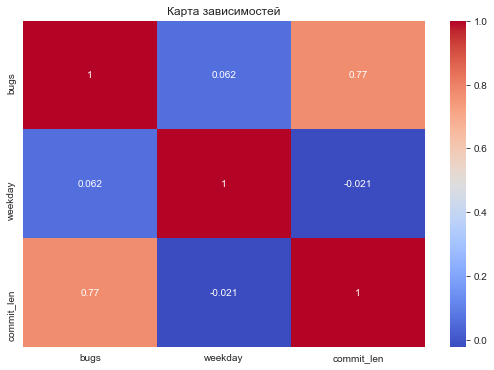

In [227]:
plt.figure(figsize=(9,6))
sns.heatmap(bugs_data.corr(), cmap='coolwarm', annot=True)
plt.title('Карта зависимостей')
plt.show()

Можно увидеть, что у `bugs` и `commit_len` высокая корреляция и равняется 0.77. На этот признак стоит обратить внимание.

Лемматизируем текст. Для этого используем библиотеку `pymystem3` для русского и `spacy` для анлийского языка.

In [228]:
def lemmatizing_sentences(sentence):
    m = Mystem()
    token_list = []
    sentence = ''.join(m.lemmatize(sentence))
    
    for token in nlp(sentence):
        token_list.append(token.lemma_)
        for trash_word in (['-PRON-', ':', '\n', '.', ',', '!', '?', '\"', '\n\n', '-', '>', ';']):
            if token.lemma_ == trash_word:
                token_list.remove(trash_word)
    
    return ' '.join(token_list)

In [229]:
%%time
bugs_data['lemmatized_commit_message'] = bugs_data['commit_message'].apply(lemmatizing_sentences)

Installing mystem to C:\Users\Vakula/.local/bin\mystem.exe from http://download.cdn.yandex.net/mystem/mystem-3.1-win-64bit.zip


Wall time: 5min 35s


In [231]:
bugs_data.head()

,repository_name,commit_author,commit_message,bugs,weekday,commit_len,lemmatized_commit_message
0,mlm,Victor,объяснения предсказаний с помощью lime,4,4,5,объяснение предсказание с помощь lime
1,mlm,Victor,Поставил lime вместо eli5,3,4,4,поставлять lime вместо eli5
2,mlm,Victor,Скрипт для создния пакетов обновления,4,3,5,скрипт для создний пакет обновление
3,mlm,Victor,Сортировка весов по убыванию,3,3,4,сортировка весы по убывание
4,mlm,Victor,не надо конвертировать массив до операции по с...,7,3,9,не надо конвертировать массив до операция по с...


Теперь мы можем выделить еще признаки, которые могут показывать наличие или отсутсвие багов.

*(В данной задаче можно было бы применить BERT, но, я считаю, что он избыточен. На Git, обычно, пушат с небольшим комментарием, где кратко излагают свои действия. BERT же хорош, но очень громоздкий для данной задачи.)*

In [232]:
bugs_data['bug_word'] = [1 if i >=0 else 0 for i in bugs_data['lemmatized_commit_message'].str.find('bug')]
bugs_data['fix_word'] = [1 if i >=0 else 0 for i in bugs_data['lemmatized_commit_message'].str.find('fix')]
bugs_data['mistake_ru_word'] = [1 if i >=0 else 0 for i in bugs_data['lemmatized_commit_message'].str.find('ошибка')]

In [234]:
bugs_data.head(10)

,repository_name,commit_author,commit_message,bugs,weekday,commit_len,lemmatized_commit_message,bug_word,fix_word,mistake_ru_word
0,mlm,Victor,объяснения предсказаний с помощью lime,4,4,5,объяснение предсказание с помощь lime,0,0,0
1,mlm,Victor,Поставил lime вместо eli5,3,4,4,поставлять lime вместо eli5,0,0,0
2,mlm,Victor,Скрипт для создния пакетов обновления,4,3,5,скрипт для создний пакет обновление,0,0,0
3,mlm,Victor,Сортировка весов по убыванию,3,3,4,сортировка весы по убывание,0,0,0
4,mlm,Victor,не надо конвертировать массив до операции по с...,7,3,9,не надо конвертировать массив до операция по с...,0,0,0
5,mlm,Peggy,Добавлено больше логирования и фикс до частичн...,6,3,8,добавлять много логирование и фикс до частичны...,0,0,0
6,mlm,Victor,"Отладка, чтоб оно хотябы запускалось",4,2,5,отладка чтоб оно хотяб запускаться,0,0,0
7,mlm,Victor,Добавил скрипт для запуска контейнера,4,2,5,добавлять скрипт для запуск контейнер,0,0,0
8,mlm,Victor,label не нужен,2,2,3,label не нужный,0,0,0
9,mlm,Victor,Установка всех зависимостей теперь в докер файле,5,2,7,установка весь зависимость теперь в докер файл,0,0,0


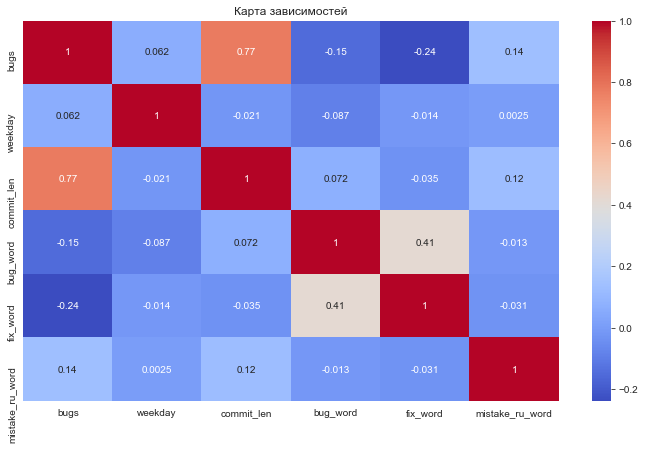

In [237]:
plt.figure(figsize=(12,7))
sns.heatmap(bugs_data.corr(), cmap='coolwarm', annot=True)
plt.title('Карта зависимостей')
plt.show()

На катре корреляций видно, что выделенные признаки имеют очень слабую корреляцию. Однако, они могут помочь найти некоторые очевидные данные.

## 3. Обучени модели

Разделим датасет на три выборки - тренировочную, валидационную и тестовую.

In [251]:
train, test = train_test_split(bugs_data.drop(['commit_message', 'lemmatized_commit_message'], axis=1), test_size=0.4, random_state=132)

In [252]:
test ,valid = train_test_split(test, test_size=0.5, random_state=132)

In [253]:
train_target, test_target, valid_target = train['bugs'], test['bugs'], valid['bugs']
train_features, test_features, valid_features = train.drop('bugs',axis=1), test.drop('bugs',axis=1), valid.drop('bugs',axis=1) 

In [254]:
bugs_data.columns

Index(['repository_name', 'commit_author', 'commit_message', 'bugs', 'weekday',
       'commit_len', 'lemmatized_commit_message', 'bug_word', 'fix_word',
       'mistake_ru_word'],
      dtype='object')

Для обучения будет использованна библиотека catboost. Она хорошо справляется с категориальными признаки и унее высокая скорость предсказания.

In [319]:
cat_features = ['repository_name', 'commit_author', 'weekday', 'bug_word', 'fix_word','mistake_ru_word']

In [320]:
cbr = CatBoostRegressor(loss_function='RMSE', learning_rate=0.4, iterations=500, depth=10)

In [321]:
%%time
cbr.fit(train_features, train_target, cat_features =cat_features, verbose=100)

0:	learn: 1.6633634	total: 36.9ms	remaining: 18.4s
100:	learn: 0.0582721	total: 970ms	remaining: 3.83s
200:	learn: 0.0382681	total: 1.73s	remaining: 2.57s
300:	learn: 0.0213885	total: 2.74s	remaining: 1.81s
400:	learn: 0.0103828	total: 3.58s	remaining: 885ms
499:	learn: 0.0039776	total: 4.27s	remaining: 0us
Wall time: 4.64 s


In [322]:
prediction = cbr.predict(valid_features).round()

In [323]:
compare_target_valid = pd.concat([valid_target.reset_index(drop=True),pd.Series(prediction)], axis=1)
compare_target_valid.columns = ['bugs','prediction']

In [324]:
compare_target_valid

,bugs,prediction
0,2,2.0
1,4,4.0
2,2,1.0
3,2,2.0
4,1,2.0
...,...,...
59,2,1.0
60,7,6.0
61,5,5.0
62,2,2.0


In [325]:
valid_rmse = mean_squared_error(valid_target, prediction)**0.5
valid_rmse

0.9519716382329886

Text(0.5, 1.0, '')

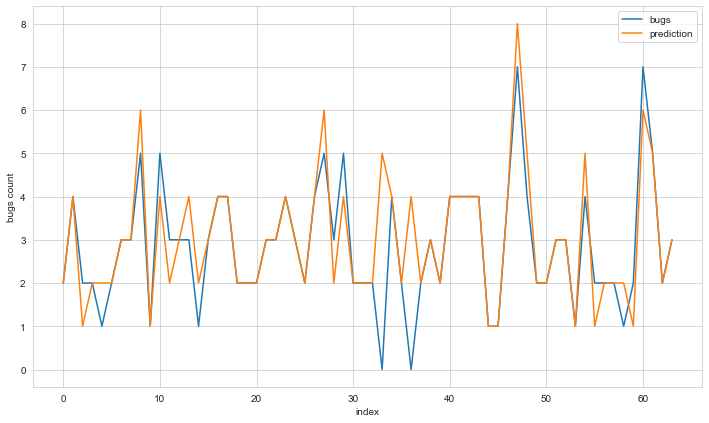

In [326]:
compare_target_valid.plot(figsize=(12,7))
plt.xlabel('index')
plt.ylabel('bugs count')
plt.title('')

### Вывод

На валидационной выборке было достигнуто значение rmse равное 0.952. Это значит, что модель в среднем ошибается на единицу. 

## 4. Проверка на тестовой выборке.

Для проверки на тестовой выборке обучим модель снова на объединенных тестовой и валидационной выборке.

In [327]:
%%time
cbr.fit(pd.concat([train_features, valid_features]), pd.concat([train_target, valid_target]), cat_features =cat_features, verbose=100)

0:	learn: 1.5510339	total: 18.6ms	remaining: 9.28s
100:	learn: 0.0450348	total: 934ms	remaining: 3.69s
200:	learn: 0.0102894	total: 1.71s	remaining: 2.54s
300:	learn: 0.0025536	total: 2.44s	remaining: 1.61s
400:	learn: 0.0007767	total: 3.16s	remaining: 781ms
499:	learn: 0.0002486	total: 3.91s	remaining: 0us
Wall time: 4.35 s


In [329]:
prediction = cbr.predict(test_features).round()

In [330]:
compare_target_test = pd.concat([test_target.reset_index(drop=True),pd.Series(prediction)], axis=1)
compare_target_test.columns = ['bugs','prediction']
compare_target_test.head(10)

,bugs,prediction
0,3,2.0
1,3,3.0
2,5,5.0
3,2,2.0
4,3,3.0
5,4,4.0
6,1,1.0
7,4,4.0
8,4,5.0
9,1,1.0


In [332]:
test_rmse = mean_squared_error(test_target, prediction)**0.5
test_rmse

0.4841229182759271

Text(0, 0.5, 'bugs count')

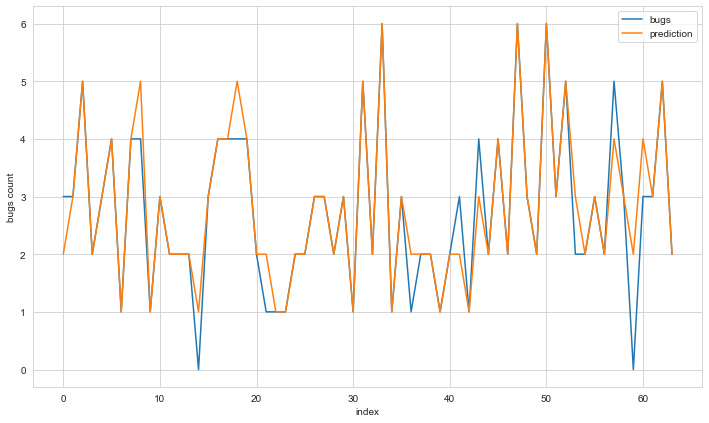

In [331]:
compare_target_test.plot(figsize=(12,7))
plt.xlabel('index')
plt.ylabel('bugs count')

RMSE на тестовой выборке получился равен 0.48. Это очень хороший результат.

Проверим модель на адекватность. Для этого используем Dummy модель.

In [333]:
dummy_model = DummyRegressor()
dummy_model.fit(pd.concat([train_features, valid_features]), pd.concat([train_target, valid_target]))

DummyRegressor(constant=None, quantile=None, strategy='mean')

In [334]:
dummy_prediction = dummy_model.predict(test_features).round()

In [335]:
compare_target_test = pd.concat([compare_target_test, pd.Series(dummy_prediction)], axis=1)
compare_target_test.columns = ['bugs','prediction', 'dummy_prediction']
compare_target_test.head(10)

,bugs,prediction,dummy_prediction
0,3,2.0,3.0
1,3,3.0,3.0
2,5,5.0,3.0
3,2,2.0,3.0
4,3,3.0,3.0
5,4,4.0,3.0
6,1,1.0,3.0
7,4,4.0,3.0
8,4,5.0,3.0
9,1,1.0,3.0


Text(0, 0.5, 'bugs count')

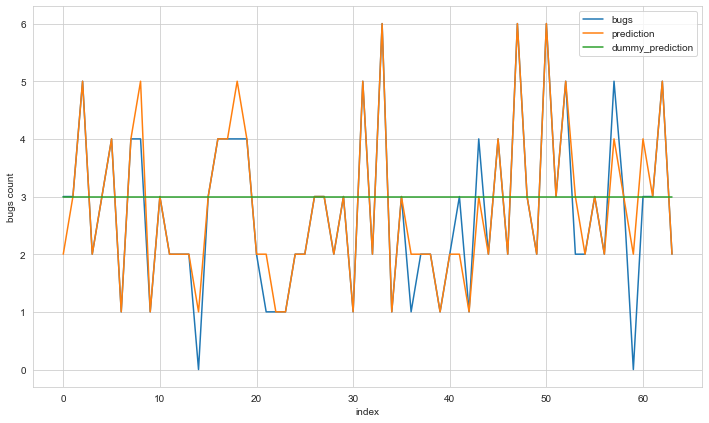

In [336]:
compare_target_test.plot(figsize=(12,7))
plt.xlabel('index')
plt.ylabel('bugs count')

In [337]:
dummi_rmse = mean_squared_error(test_target, dummy_prediction)**0.5
dummi_rmse

1.4415703243338496

### Выводы

RMSE на тестовой выборке получился равен 0.48, тогда как на dummi модел дала результат, равный 1.44. Это говорит о том, что модель имеет смысл и может быть использованна для предсказания реальных данных. 

## 5. Общие выводы

Задача стояла разработать модель, которая предсказывавала число багов. Из начальных данных были удалены все столбцы, кроме столбцов с коммитами. Также было найдено, что число багов сильно зависит от числа слов в пуше. Далее были в ручную выделенны еще 3 зависимости из текста для улучшения результата модели. 

Модель была выбрана случайный лес. В результате удалось достигнуть результат RMSE на тестовой выборке равный 0.48. Это практически в 3 раза лучше результата средней модели (dummy_model).

Я бы рекомендовал расширить набор данных для улучшения качества предсказания.